In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Dataset

data source:https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [189]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("./datasets/SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)
df.head()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [190]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [191]:
df

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
8652,752,9.1,57,1.1,562,1.0,1.69,0.0,0.0,1
8676,672,9.3,61,1.5,390,2.1,0.85,0.0,0.0,1
8700,635,7.9,14,1.7,1688,-18.0,1.81,0.0,0.0,1
8724,661,5.6,27,0.3,1522,-11.9,0.34,0.0,0.0,1


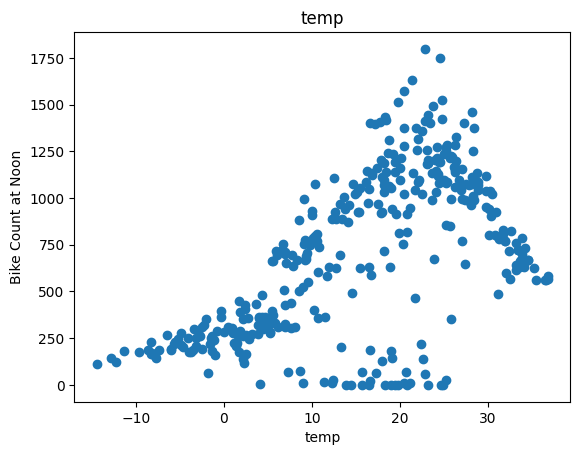

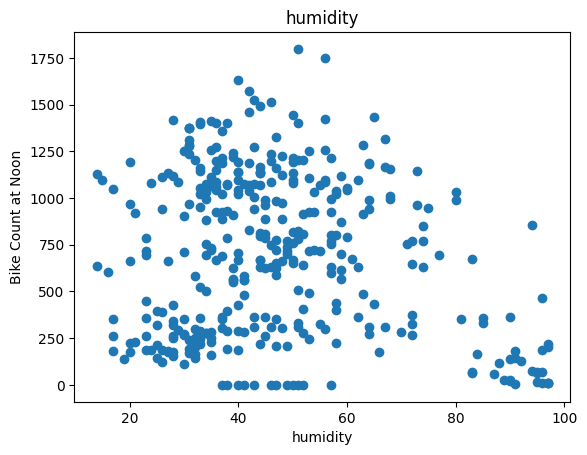

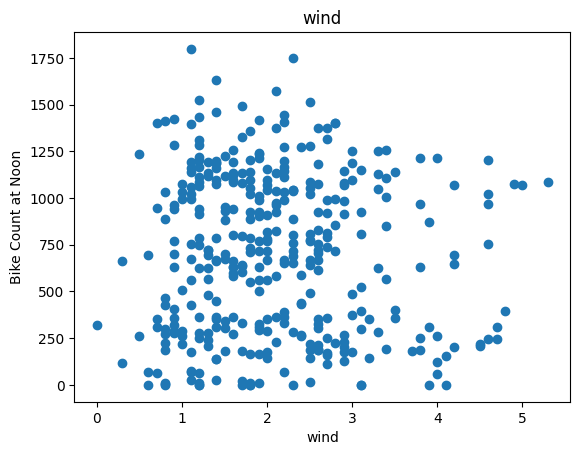

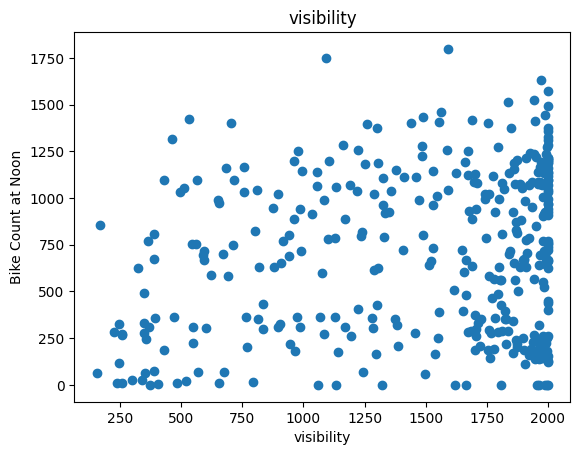

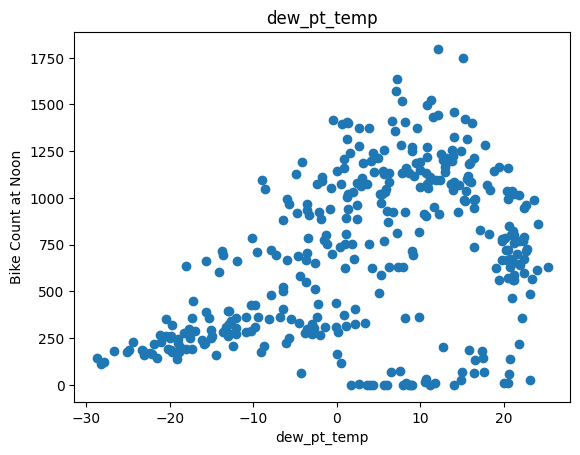

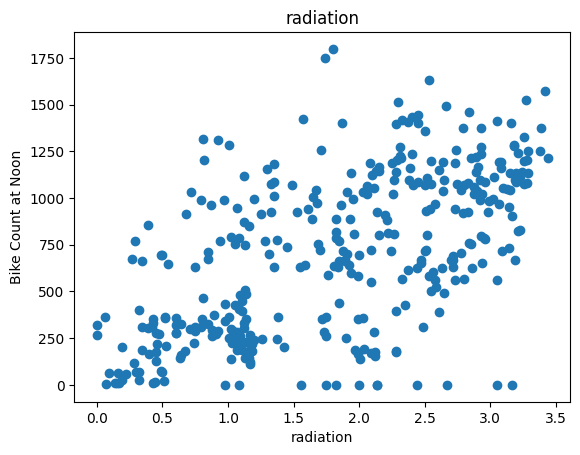

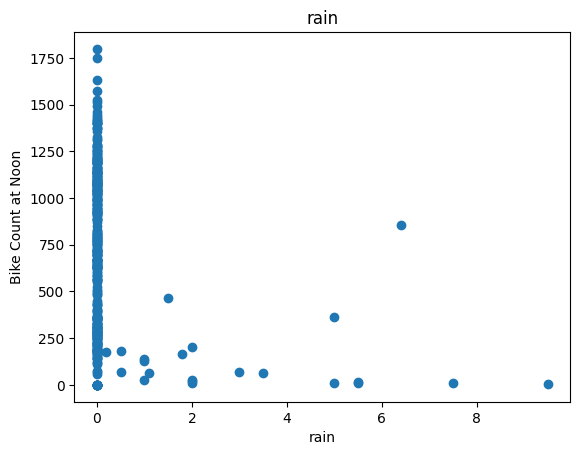

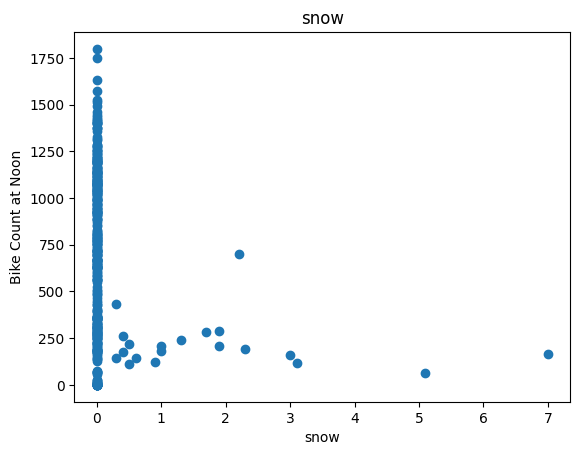

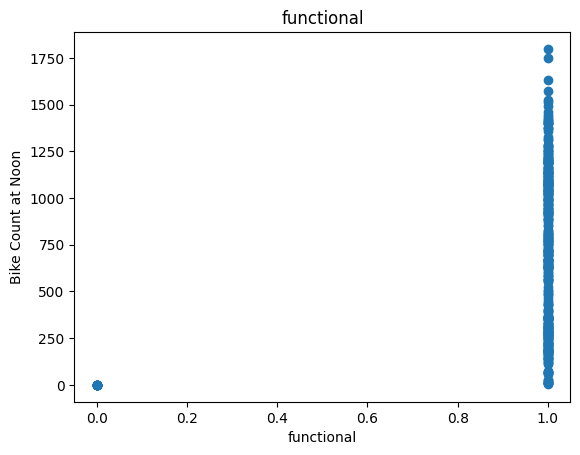

In [192]:
for label in df.columns[1:]:
    plt.scatter(df[label], df['bike_count'])
    plt.title(label)
    plt.ylabel('Bike Count at Noon')
    plt.xlabel(label)
    plt.show()

In [193]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)


In [194]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/Valid/Test dataset

In [195]:
train, valid, test  = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df)) ])

/home/kalzumaki/.local/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [196]:
def get_xy(dataframe, y_label, x_labels = None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values
            
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))
    
    return data, X, y

In [197]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=['temp'])
_, X_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=['temp'])

In [198]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [199]:
print(temp_reg.coef_, temp_reg.intercept_)

[[21.39306247]] [380.81542109]


In [200]:
temp_reg.score(X_test_temp, y_test_temp)

0.2609629971954629

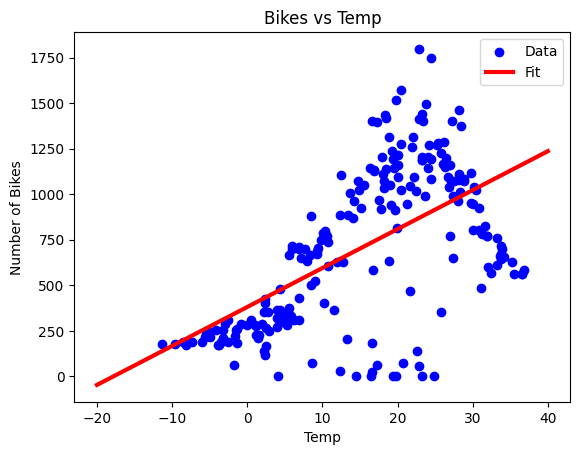

In [201]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='b')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='r', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

# Multiple Linear Regression

In [202]:
train, valid, test  = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df)) ])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_valid_all, y_valid_all = get_xy(valid, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

/home/kalzumaki/.local/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [203]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [204]:
all_reg.score(X_test_all, y_test_all)

0.5100189503457814

# Regression with Neural Network

In [205]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [206]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

/home/kalzumaki/.local/lib/python3.13/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [207]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [208]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [209]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_valid_temp, y_valid_temp)
)

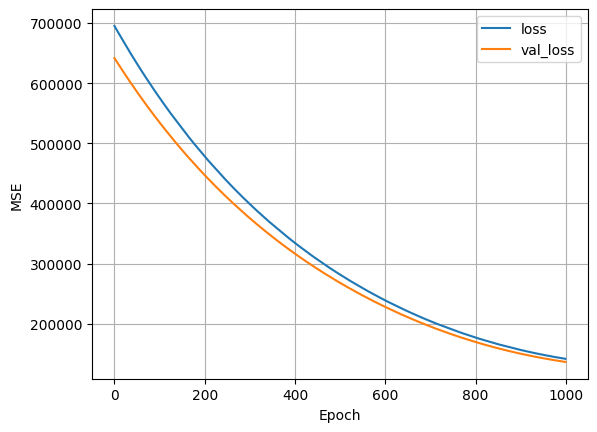

In [210]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


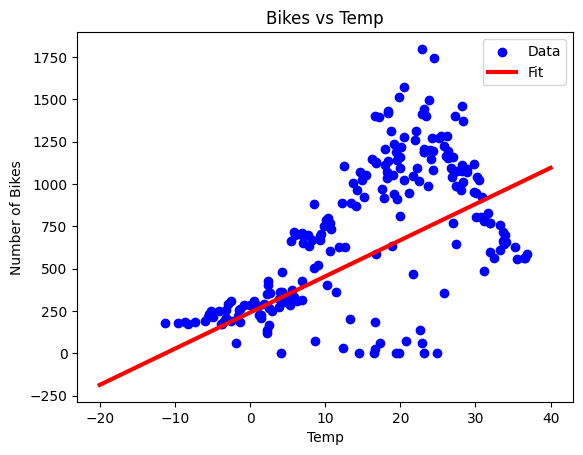

In [211]:
# NN
plt.scatter(X_train_temp, y_train_temp, label='Data', color='b')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='r', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

# NEURAL NETWORK

In [212]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [213]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [214]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_valid_temp, y_valid_temp),
    verbose=0,
    epochs=100
)

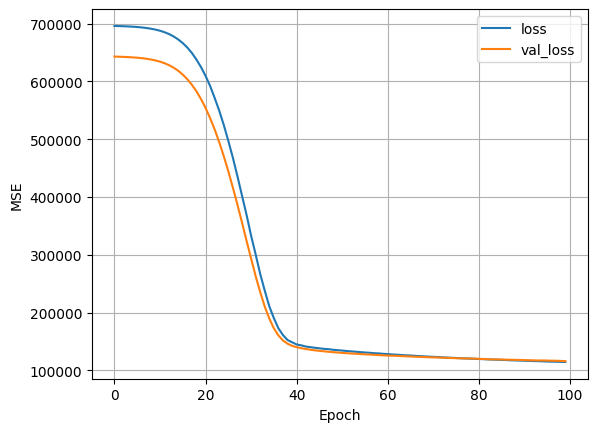

In [215]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


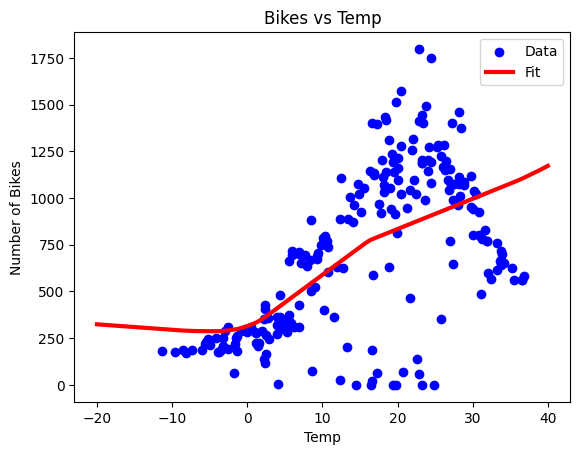

In [216]:

plt.scatter(X_train_temp, y_train_temp, label='Data', color='b')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label='Fit', color='r', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

for all

In [227]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=None)
all_normalizer.adapt(X_train_all)



/home/kalzumaki/.local/lib/python3.13/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [228]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [229]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_valid_all, y_valid_all),
    verbose=0,
    epochs=100
)

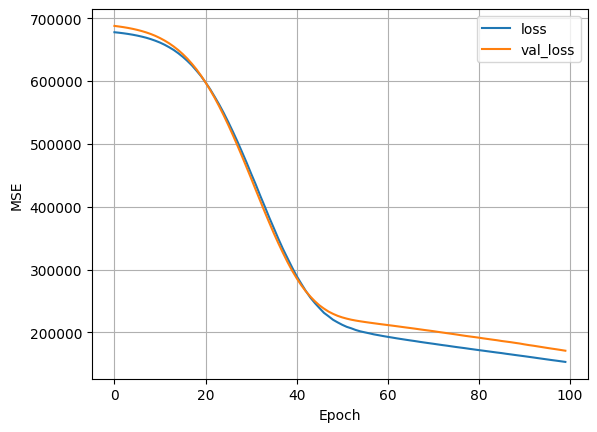

In [230]:
plot_loss(history)

In [232]:
# calculate  the  MSE for both linear reg and nn
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn =  nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 773ms/step


In [233]:
def MSE(y_pred, y_real):
   return (np.square(y_pred - y_real)).mean()
    

In [234]:
MSE(y_pred_lr, y_test_all)

np.float64(87859.7147832568)

In [235]:
MSE(y_pred_nn, y_test_all)

np.float64(160939.31766810844)

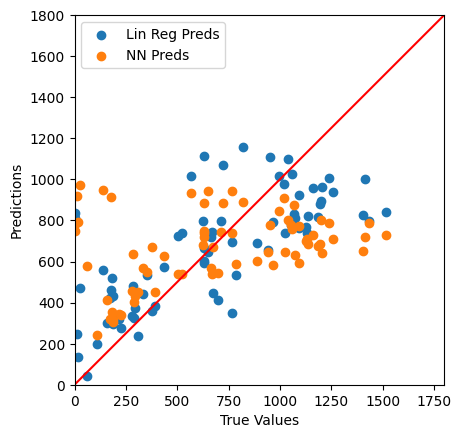

In [237]:
ax =plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 1800] # limits
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')
